In [24]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [25]:
# Load data
csv_files = glob.glob(os.path.join('datasets/tracks', "*.csv"))
tracks_dfs = [pd.read_csv(filename) for filename in csv_files]
tracks_dfs[0].head()

column_x = '# x_m'
column_y = 'y_m'

In [26]:
# Normalization
for df in tracks_dfs:
    df[column_x] = (df[column_x] - df[column_x].min()) / (df[column_x].max() - df[column_x].min())
    df[column_y] = (df[column_y] - df[column_y].min()) / (df[column_y].max() - df[column_y].min())

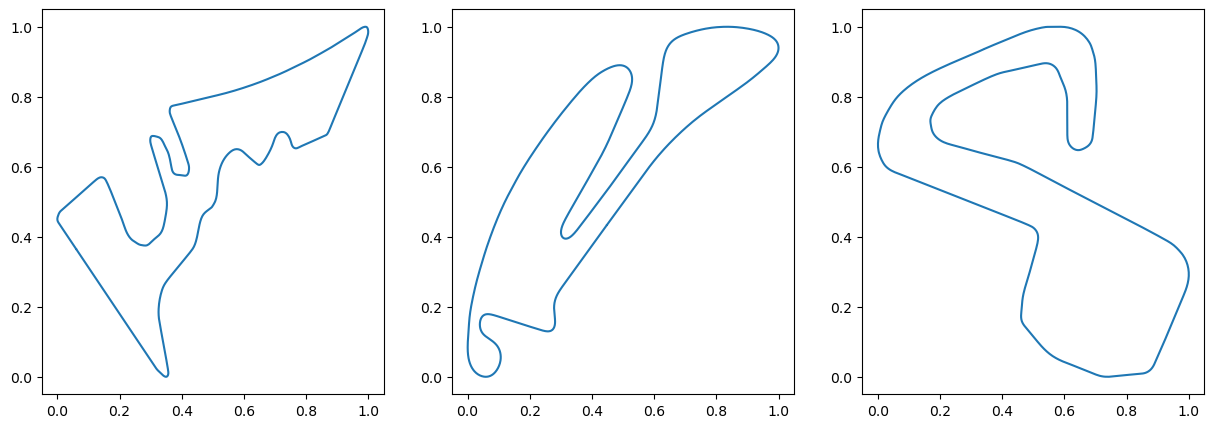

In [27]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, df in enumerate(tracks_dfs[:3]):
    axs[i].plot(df[column_x], df[column_y])
plt.show()

In [28]:
# Create dataloaders
def create_sequences(data, seq_length=20):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, 0:2]  # Predicting next x, y coordinates
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


def create_circular_sequences(data, seq_length=20):
    xs = []
    ys = []
    data_length = len(data)
    for i in range(data_length):  # Iterate over each point in the data
        # For x, select data from i to i+seq_length, wrapping around if necessary
        if i + seq_length < data_length:
            x = data[i:(i + seq_length), :]
        else:
            # Wrap around by concatenating the end of the data with the beginning
            x = np.concatenate((data[i:data_length, :], data[0:(i + seq_length - data_length), :]), axis=0)

        # For y, the next point after x, also wrapping around if at the end
        y_index = (i + seq_length) % data_length  # Wrap around index for y
        y = data[y_index, 0:2]  # Predicting next x, y coordinates

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


train_loaders = []
validation_loaders = []
for df in tracks_dfs:
    data = df.to_numpy()
    X, y = create_circular_sequences(data)
    X_tensor, y_tensor = torch.Tensor(X), torch.Tensor(y)
    dataset = TensorDataset(X_tensor, y_tensor)
    train_set, validation_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)
    train_loaders.append(train_loader)
    validation_loaders.append(validation_loader)

In [29]:
class RacingLinePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RacingLinePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 2)  # predicting x, y coordinates

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


if os.path.exists('model.ckpt') and input(f"A model has been found. Do you want to load it? (y/n): ") == 'y':
    model = RacingLinePredictor(input_size=4, hidden_size=128, num_layers=2)
    model.load_state_dict(torch.load('model.ckpt'))
else:
    model = RacingLinePredictor(input_size=4, hidden_size=128, num_layers=2)


def train(num_epochs, train_loaders, model, device):
    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        for train_loader in train_loaders:
            for batch_x, batch_y in train_loader:
                # Move data to the correct device
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                # Forward pass
                outputs = model(batch_x)
                loss = loss_function(outputs, batch_y)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')

    torch.save(model.state_dict(), 'model.ckpt')

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

if input("Do you want to train the model? (y/n): ") == 'y':
    train(10, train_loaders, model, device)

Using device: cuda


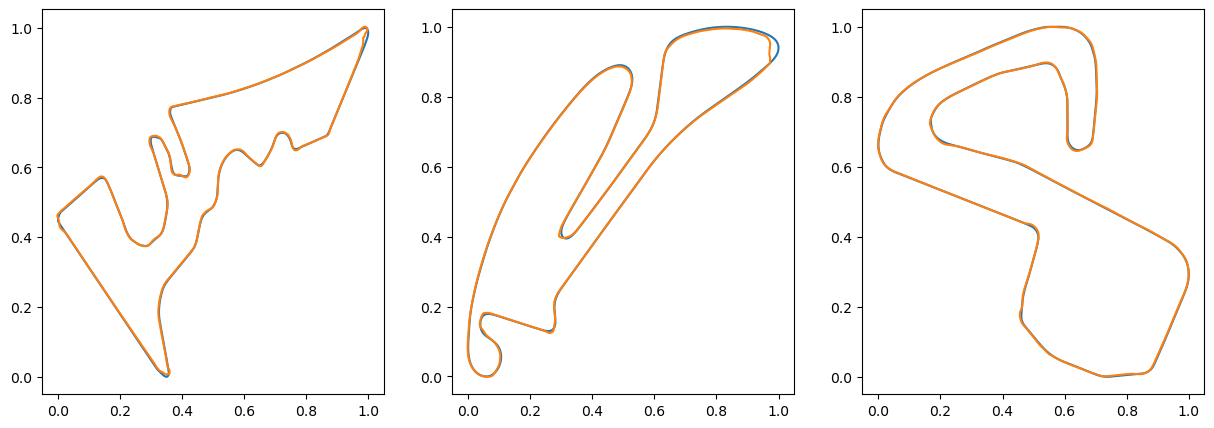

In [31]:
predictions = []
for df in tracks_dfs[:3]:
    data = df.to_numpy()
    X, y = create_circular_sequences(data)
    X_tensor, y_tensor = torch.Tensor(X), torch.Tensor(y)
    X_tensor = X_tensor.to(device)
    y_pred = model(X_tensor)
    y_pred = y_pred.detach().cpu().numpy()
    predictions.append(y_pred)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, df in enumerate(tracks_dfs[:3]):
    axs[i].plot(df[column_x], df[column_y])
    axs[i].plot(predictions[i][:, 0], predictions[i][:, 1])
plt.show()